<b> Predict Sales  
    Data Description: </b>
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge. Then:

1. for the list of shops and products I should then create a data frame that can be extended with the new lists.
2. target feature —> total amount of a given product sold in a given shop per month
3. item_cnt_day (# of product sold in a given day)
Then I should create a column item_cnt_month

<b> Features: </b>  
ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,…, October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category  

<a id='table_of_contents'></a>

0. [Import Packages](#imports_packages)  
1. [Import Data](#imports_data)
2. [Data Exploration](#data_exploration)
3. [Data Cleaning](#data_cleaning)
4. [Data Preparation](#data_preparation)
5. [Feature Engineering](#feature_engineering)
6. [Benchmark Modelling](#benchmark_modelling)
7. [Evaluation of the Model](#evaluating_model)


# 0. Import Packages <a id='imports_packages'></a>
[Back to top](#table_of_contents)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Import Data <a id='imports_data'></a>
[Back to top](#table_of_contents)

#### Item Categories

In [2]:
item_categories = pd.read_csv('Data/item_categories.csv')

In [3]:
item_categories.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


#### Item List 

In [4]:
item_list = pd.read_csv('Data/items.csv')
item_list.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


<AxesSubplot:>

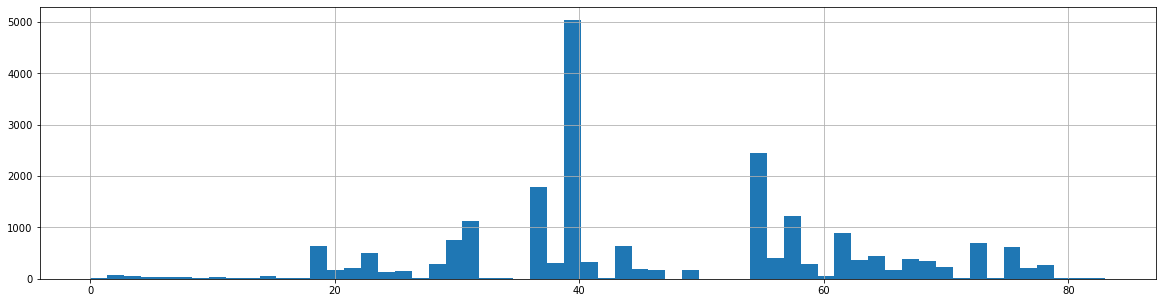

In [5]:
item_list['item_category_id'].hist(figsize=(20,5), bins=60)

In [6]:
print(item_list['item_id'].nunique(), 'unique items')

22170 unique items


In [7]:
for i in 40, 55, 37, 31:
    print(item_categories[item_categories['item_category_id']==i].item_category_name)

40    Кино - DVD
Name: item_category_name, dtype: object
55    Музыка - CD локального производства
Name: item_category_name, dtype: object
37    Кино - Blu-Ray
Name: item_category_name, dtype: object
31    Игры PC - Цифра
Name: item_category_name, dtype: object


* There are 22170 different items in the store and the features of them --> item_id, item_category_id
* Most of the items belong to item_category #40 which is "Кино - DVD"

In [8]:
item_id_list = item_list[['item_id', 'item_category_id']]

#### Shops

In [9]:
shops = pd.read_csv('Data/shops.csv')
shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [10]:
shops.loc[shops['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

There are duplicates which are:

In [11]:
print(shops['shop_name'][57], shops['shop_name'][0])
print(shops['shop_name'][58], shops['shop_name'][1])
print(shops['shop_name'][10], shops['shop_name'][11])

Якутск Орджоникидзе, 56 !Якутск Орджоникидзе, 56 фран
Якутск ТЦ "Центральный" !Якутск ТЦ "Центральный" фран
Жуковский ул. Чкалова 39м? Жуковский ул. Чкалова 39м²


#### These should be removed.

#### Sample Submission

A sample submission file in the correct format. Like a hint?

In [12]:
sample_sub = pd.read_csv('Data/sample_submission.csv')
sample_sub.head(2)

,ID,item_cnt_month
0,0,0.5
1,1,0.5


#### Training Set

The training set. Daily historical data from January 2013 to October 2015.

In [13]:
sales_train = pd.read_csv('Data/sales_train.csv')
sales_train.head(3)
#sales_train[sales_train['shop_id']==0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


#### Testing Set

The test set. You need to forecast the sales for these shops and products for November 2015.

In [14]:
sales_test = pd.read_csv('Data/test.csv')
print(sales_test.shape)
sales_test.head(2)

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [15]:
sales_test.isna().sum()
#sales_train.isna().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [16]:
sales_test.dtypes

ID         int64
shop_id    int64
item_id    int64
dtype: object

In [17]:
sales_test['item_id'].value_counts()

2049     42
6743     42
13266    42
21342    42
17244    42
         ..
7338     42
1193     42
3240     42
13359    42
2047     42
Name: item_id, Length: 5100, dtype: int64

#### Each item type appears 42 times in the test_data. 5100/22170 item types are represented in the test set.

# 2. Data Exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

#### Checking daily sold item numbers and item prices:

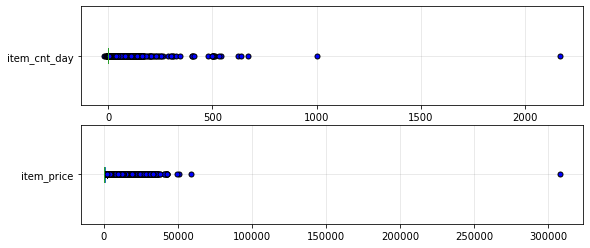

In [18]:
flierprops = dict(marker='o', markerfacecolor='blue', markersize=5, markeredgecolor='black')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[9, 4])
sales_train.plot.box(ax=axes[0], x='item_id', y='item_cnt_day', flierprops=flierprops, vert=False)
sales_train.plot.box(ax=axes[1], x='item_id', y='item_price', flierprops=flierprops, vert=False)

ax = plt.gca()
#axes[0].set_xlabel('days')
#axes[1].set_xlabel('price')
axes[0].grid(axis='both', color='gray', alpha=.2)
axes[1].grid(axis='both', color='gray', alpha=.2)
plt.show()


#### There are negative price and days in addition to outliers. We should remove them.

In [19]:
len(sales_train[sales_train['item_cnt_day']<0])

7356

* There are 7356 negative item_cnt_day (# of product counts cannot be negative. However, could -1 mean product return? )

* What is the currency? Do these number make sense? Which products cost the mosts?

In [20]:
#sales_train_sorted_on_price = sales_train.sort_values('item_price', ascending=False)

In [21]:
sales_train.loc[sales_train.item_price.idxmax()]

date              13.12.2013
date_block_num            11
shop_id                   12
item_id                 6066
item_price          307980.0
item_cnt_day             1.0
Name: 1163158, dtype: object

In [22]:
print(item_list[item_list['item_id']==6066])
print(shops[shops['shop_id']==12])

                 item_name  item_id  item_category_id
6066  Radmin 3  - 522 лиц.     6066                75
              shop_name  shop_id
12  Интернет-магазин ЧС       12


I googled it and saw that Radmin 3  - 522 лиц is a remote control software.20 dollars  
Only one shop sells this product. 
307980 russian ruble is 4381.04 USD in October 2021. Thus, the price listed for this product may be unreal. Considering that we do not have any other sample for this product, we may thinking about removing this item from the list. However, I will keep for now.

In [23]:
sales_train['item_id'].nunique()

21807

#### There were 22k item types sold. However, there are 21k of them in the training set.

# 3. Data Cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

1. Removing duplicates
2. Negative item_cnt_day  
3. Negative item prices  
4. Outlier prices and cnt_days

#### Removing duplicated in shop.csv:

In [24]:
print('train')

print(sales_train[sales_train['shop_id']==0].shape)  # = 57
print(sales_train[sales_train['shop_id']==1].shape)  # = 58
print(sales_train[sales_train['shop_id']==11].shape) # = 10
print(sales_train[sales_train['shop_id']==57].shape) # = 0
print(sales_train[sales_train['shop_id']==58].shape) # = 1
print(sales_train[sales_train['shop_id']==10].shape) # = 11

print('test')

print(sales_test[sales_test['shop_id']==0].shape)  # = 57
print(sales_test[sales_test['shop_id']==1].shape)  # = 58
print(sales_test[sales_test['shop_id']==11].shape) # = 10
print(sales_test[sales_test['shop_id']==57].shape) # = 0
print(sales_test[sales_test['shop_id']==58].shape) # = 1
print(sales_test[sales_test['shop_id']==10].shape) # = 11


train
(9857, 6)
(5678, 6)
(499, 6)
(117428, 6)
(71441, 6)
(21397, 6)
test
(0, 3)
(0, 3)
(0, 3)
(5100, 3)
(5100, 3)
(5100, 3)


0, 1, and 10 should be removed.

In [25]:
shops_cleaned = shops.copy()
shops_cleaned = shops_cleaned.drop([0, 1, 10]).reset_index()

Duplicate shop_id should also be adjusted in sales_train and sales_test data frames.

In [26]:
sales_train.loc[sales_train.shop_id==0, 'shop_id'] = 57
sales_train.loc[sales_train.shop_id==1, 'shop_id'] = 58
sales_train.loc[sales_train.shop_id==10, 'shop_id'] = 11

sales_test.loc[sales_test.shop_id==0, 'shop_id'] = 57
sales_test.loc[sales_test.shop_id==1, 'shop_id'] = 58
sales_test.loc[sales_test.shop_id==10, 'shop_id'] = 11

#### Removing negative item_cnt_day:

In [27]:
sales_train_cleaned = sales_train.copy()
len(sales_train_cleaned[(sales_train_cleaned['item_cnt_day']<0)])

7356

7356 is not a significant amount of data points to remove given the size of the whole dataset. Thus, I prefer removing them.

In [28]:
print(sales_train_cleaned.shape)
sales_train_cleaned = sales_train_cleaned[(sales_train_cleaned['item_cnt_day']>0)]
print(sales_train_cleaned.shape)

(2935849, 6)
(2928493, 6)


#### Removing native and outlier item prices.

In [29]:
sales_train_cleaned = sales_train_cleaned[(sales_train_cleaned['item_price']>0) & (sales_train_cleaned['item_price']<100000)]
print(sales_train_cleaned.shape)

(2928491, 6)


In [30]:
sales_train_cleaned.sort_values('item_price', ascending=False).head(7)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,17.09.2013,8,12,11365,59200.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0
2327159,29.01.2015,24,12,7241,49782.0,1.0
2910156,29.10.2015,33,12,13403,42990.0,1.0
2931380,20.10.2015,33,22,13403,42990.0,1.0
2917760,20.10.2015,33,3,13403,42990.0,1.0
2885692,23.10.2015,33,42,13403,42990.0,1.0


In [31]:
item_list[item_list['item_id']==13199] #made up a number

,item_name,item_id,item_category_id
13199,Коллекционные шахматы (Властелин Колец),13199,69


This is a Lord of the Rings Chess Set. In 2021, it costs 731 USD which makes this datapoint a meaningful one.

# 4. Data Preparation<a id='data_preparation'></a>
[Back to top](#table_of_contents)

In [118]:
sales_train_prepared = sales_train_cleaned.copy()

In [119]:
sales_train_prepared.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

#### Let's convert the date into datetime.

In [120]:
sales_train_prepared['date'] = pd.to_datetime(sales_train_prepared['date'], dayfirst=True)
sales_train_prepared['salesYear'] = sales_train_prepared['date'].dt.year
sales_train_prepared['salesMonth'] = sales_train_prepared['date'].dt.month
sales_train_prepared['salesDay'] = sales_train_prepared['date'].dt.day
sales_train_prepared.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,salesYear,salesMonth,salesDay
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15
5,2013-01-10,0,25,2564,349.00,1.0,2013,1,10


In [121]:
#item_id_list = item_list[['item_id', 'item_category_id']]
sales_train_prepared = sales_train_prepared.merge(item_id_list, left_on='item_id', right_on='item_id', how='left')
sales_train_prepared.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,salesYear,salesMonth,salesDay,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,2013,1,2,37
1,2013-01-03,0,25,2552,899.0,1.0,2013,1,3,58


In [122]:
sales_train_grouped_by_year = sales_train_prepared.groupby(['salesYear']).agg({'item_cnt_day':'sum'}).rename(columns={'item_cnt_day':'total_cnt_year'}, inplace=False).reset_index()
sales_train_grouped_by_year.head(2)

,salesYear,total_cnt_year
0,2013,1565895.0
1,2014,1323594.0


In [123]:
sales_train_grouped_by_month = sales_train_prepared.groupby(['salesYear', 'salesMonth']).agg({'item_cnt_day':'sum'}).rename(columns={'item_cnt_day':'total_cnt_month'}, inplace=False).reset_index()
sales_train_grouped_by_month.head(2)

,salesYear,salesMonth,total_cnt_month
0,2013,1,131850.0
1,2013,2,128382.0


### Plotting total sales per month for 2013, 2014, and 2015.

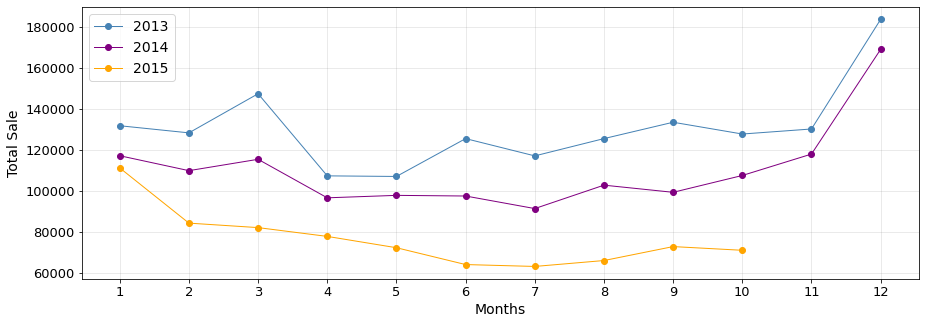

In [124]:
plt.figure(figsize=(15,5))
# Plot the sales of the year 2013
plt.plot(sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2013]['salesMonth'], sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2013]['total_cnt_month'], '-o', color='steelblue', linewidth=1, label='2013')
plt.plot(sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2014]['salesMonth'], sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2014]['total_cnt_month'], '-o', color='purple', linewidth=1, label='2014')
plt.plot(sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2015]['salesMonth'], sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2015]['total_cnt_month'], '-o', color='orange', linewidth=1, label='2015')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Months', fontsize=14)
plt.ylabel('Total Sale', fontsize=14)

ax = plt.gca()
ax.grid(axis='both', color='gray', alpha=.2)
#ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.xaxis.set_ticks(np.arange(1, 13, 1))
plt.show()

In [125]:
sales_train_prepared.loc[:,'item_cnt_day'] = sales_train_prepared['item_cnt_day'].astype(int)
sales_train_prepared.dtypes

date                datetime64[ns]
date_block_num               int64
shop_id                      int64
item_id                      int64
item_price                 float64
item_cnt_day                 int64
salesYear                    int64
salesMonth                   int64
salesDay                     int64
item_category_id             int64
dtype: object

In [126]:
sales_train_grouped_by_item = sales_train_prepared.groupby(['salesYear', 'item_id']).agg({'item_cnt_day':'sum'}).reset_index().rename(columns={'item_cnt_day':'total_cnt_year'})
print(sales_train_grouped_by_item.shape)
#sales_train_grouped_by_item.loc[:,'item_id'] = sales_train_grouped_by_item['item_id'].astype(str)
sales_items_2013 = sales_train_grouped_by_item[sales_train_grouped_by_item['salesYear']==2013].sort_values('total_cnt_year', ascending=False).reset_index()
sales_items_2014 = sales_train_grouped_by_item[sales_train_grouped_by_item['salesYear']==2014].sort_values('total_cnt_year', ascending=False).reset_index()
sales_items_2015 = sales_train_grouped_by_item[sales_train_grouped_by_item['salesYear']==2015].sort_values('total_cnt_year', ascending=False).reset_index()

sales_train_grouped_by_item.head(2)

(40317, 3)


,salesYear,item_id,total_cnt_year
0,2013,12,1
1,2013,19,1


### Comparing the total sales of the top 15 best-seller of each year.

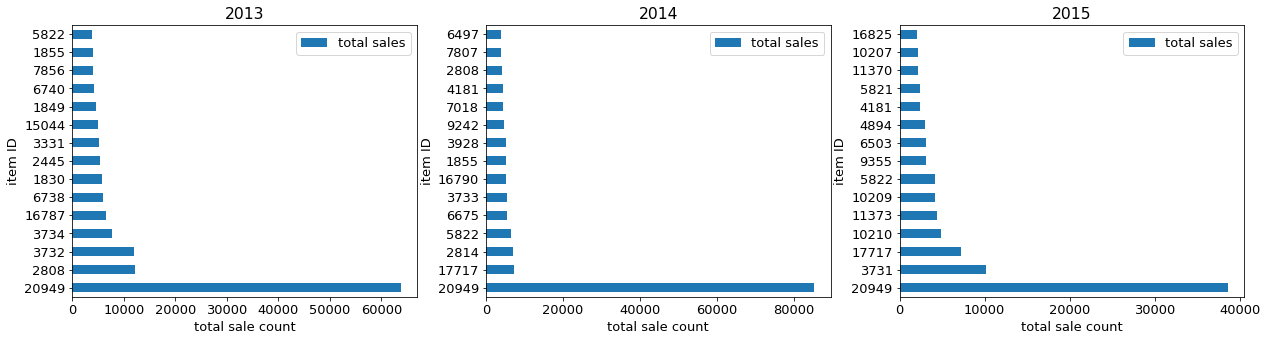

In [127]:
plt.rcParams.update({'font.size': 13}) # must set in top

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[21, 5])

sales_items_2013[0:15].plot(ax=axes[0], x='item_id', y='total_cnt_year', kind='barh', title='2013', label = 'total sales')
sales_items_2014[0:15].plot(ax=axes[1], x='item_id', y='total_cnt_year', kind='barh', title='2014', label = 'total sales')
sales_items_2015[0:15].plot(ax=axes[2], x='item_id', y='total_cnt_year', kind='barh', title='2015', label = 'total sales')

for i in (0,1,2):
    axes[i].set_ylabel('item ID')
    axes[i].set_xlabel('total sale count')

### Plotting # of product sold per category during Jan 2013-Oct 2015: item_category_id vs item_cnt_day

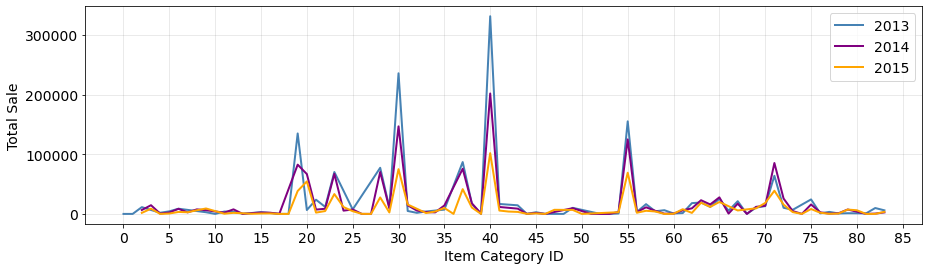

In [128]:
#sales_train_grouped_by_category.loc[:, 'item_category_id']=sales_train_grouped_by_category['item_category_id'].astype(int)
plt.rcParams.update({'font.size': 14}) # must set in top

sales_train_grouped_by_category = sales_train_prepared.groupby(['item_category_id', 'salesYear']).agg({'item_cnt_day': 'sum'}).reset_index().rename(columns={'item_cnt_day':'total_cnt'})
sales_train_grouped_by_category = sales_train_grouped_by_category.sort_values('item_category_id')
#sales_train_grouped_by_category.reset_index().plot(y='total_cnt', x='item_category_id', kind='line', figsize=(20,5), xlabel='category ID', ylabel='total sales', fontsize=14)

fig, ax = plt.subplots(figsize=(15,4))
plt.plot(sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2013]['item_category_id'], sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2013]['total_cnt'], color='steelblue', linewidth=2, label='2013')
plt.plot(sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2014]['item_category_id'], sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2014]['total_cnt'], color='purple', linewidth=2, label='2014')
plt.plot(sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2015]['item_category_id'], sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2015]['total_cnt'], color='orange', linewidth=2, label='2015')

ax = plt.gca()
ax.set_xlabel('Item Category ID')
ax.set_ylabel('Total Sale')
ax.legend()
ax.grid(axis='both', color='gray', alpha=.2)
ax.xaxis.set_ticks(np.arange(0, 90, 5))

plt.show()


In [129]:
sales_train_grouped_by_category = sales_train_grouped_by_category.merge(item_categories[['item_category_id', 'item_category_name']], left_on='item_category_id', right_on='item_category_id', how='left')
sales_train_grouped_by_category.sort_values(['salesYear', 'total_cnt'], ascending=False)

sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2013]['total_cnt'].sum()

1565895

2013: the total sale amount of the top 15 best selling items is 1304002/1565895 = 83.28%
2014: the total sale amount of the top 15 best selling items is 1048377/1323594 = 79.21%
2015: the total sale amount of the top 15 best selling items is 580259/766256 = 75.73%


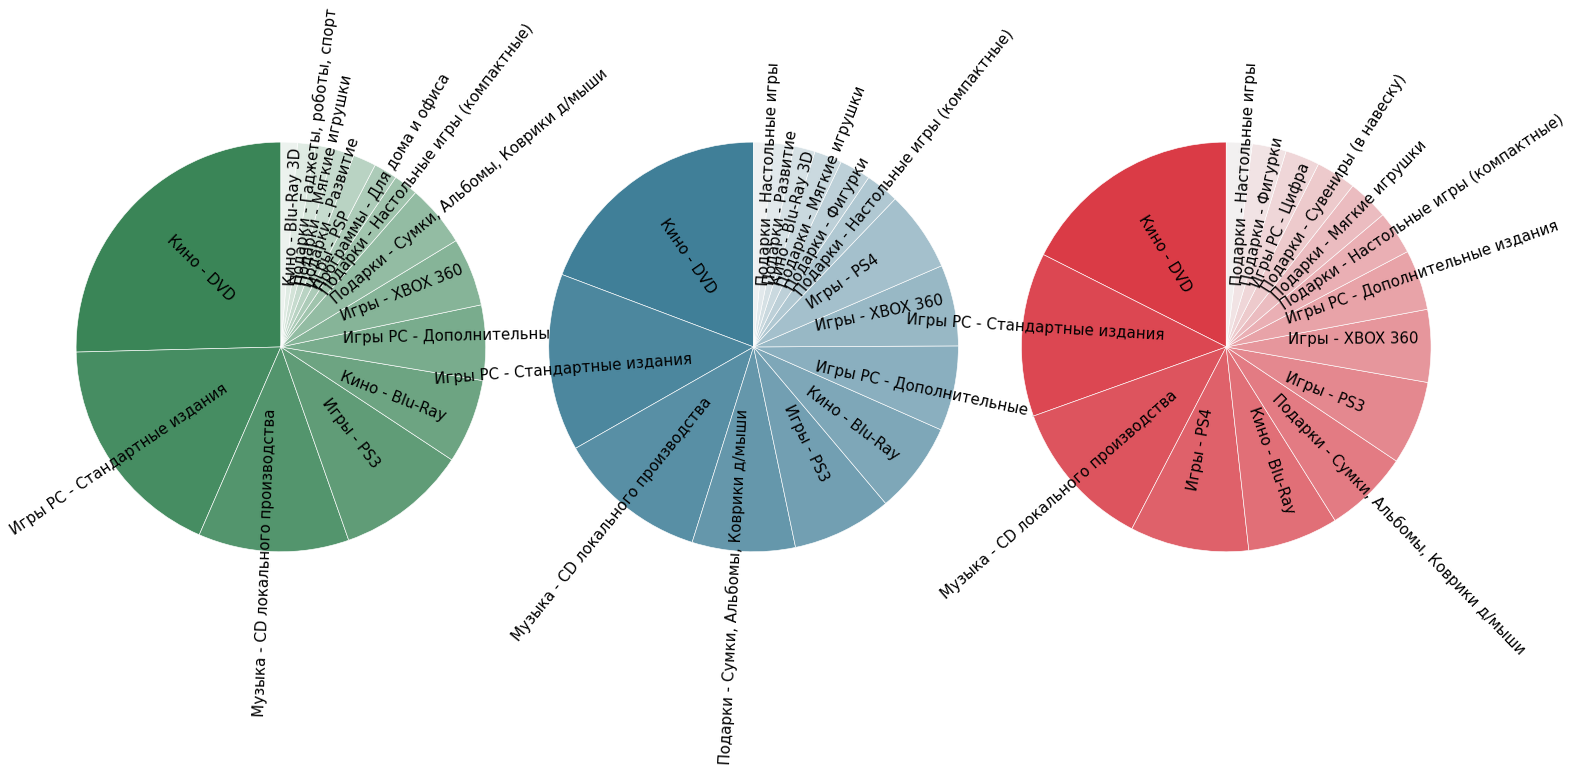

In [130]:
top_n = 15


def pie_ratio(year, cat_count):
    total_sales_year = sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==year]['total_cnt'].sum()
    ratio = cat_count/total_sales_year*100
    return "{0}: the total sale amount of the top {1} best selling items is {2}/{3} = {4:.2f}%".format(year, top_n, cat_count, total_sales_year, ratio)


years = [2013, 2014, 2015]
fig, axes = plt.subplots(1, 3, figsize=(24,10))


#colors of the pie charts
colors = {}
for year in years:
    colors[year] = []

import seaborn as sns
colors[2013] = sns.light_palette((860, 75, 50), input='husl',reverse=True, n_colors=15)
colors[2014] = sns.light_palette((226, 75, 50), input='husl',reverse=True, n_colors=15)
colors[2015] = sns.light_palette((730, 75, 50), input='husl', reverse=True, n_colors=15)

#plotting the pie charts
top = {}
for i in range(0,3):
    year = years[i]
    top[year] = sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==year].sort_values('total_cnt', ascending=False)[0:15]
    print(pie_ratio(year, top[year].total_cnt.sum()))
    axes[i].pie(top[year].total_cnt, labels=top[year].item_category_name, radius=1.3, labeldistance=.3, 
            rotatelabels=True, textprops={'color':"k", 'fontsize': 15}, startangle=90, wedgeprops={"edgecolor":"1",'linewidth': .6}, colors = colors[year])

### Plotting # of products sold over the months and the years: date_block_num vs item_cnt_day

<AxesSubplot:xlabel='date_block_num'>

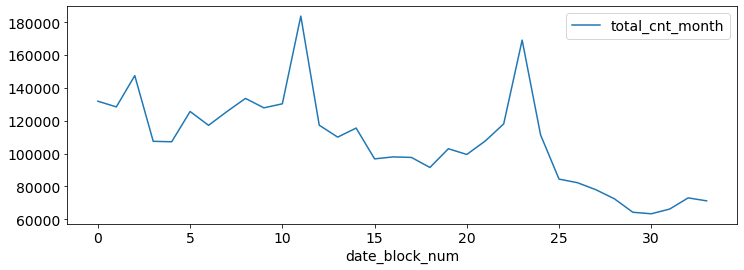

In [131]:
sales_train_grouped_by_block = sales_train_prepared.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index().rename(columns={'item_cnt_day':'total_cnt_month'})
sales_train_grouped_by_block.columns
sales_train_grouped_by_block.plot(y='total_cnt_month', x='date_block_num', figsize=(12,4))




In [132]:
#check
#a= sales_train_prepared[sales_train_prepared['date_block_num']==0]['item_cnt_day'].sum()
#print(a)
#b= sales_train_prepared[sales_train_prepared['date_block_num']==1]['item_cnt_day'].sum()
#print(b)
#sales_train_grouped_by_block.head(2)

The general trend is a decrease in the sales over time even though there are sharp increases and decreases.

In [133]:
sales_test_prepared = sales_test.merge(item_id_list, left_on='item_id', right_on='item_id', how='left')
sales_test_prepared.head(2) 

sales_test_prepared = sales_test_prepared.drop('ID', axis=1)
sales_test_prepared.head(1)

,shop_id,item_id,item_category_id
0,5,5037,19


The aim is to predict the sales for the items and shops given in test set for November 2015. Thus, we should add a column named 'date_block_num' to test set and set all the values in this column to 34.

In [134]:
sales_test_prepared['date_block_num'] = 34
sales_test_prepared['salesYear'] = 2015
sales_test_prepared['salesMonth'] = 11
print(sales_train_prepared.shape)
sales_test_prepared.head(2)

(2928491, 10)


,shop_id,item_id,item_category_id,date_block_num,salesYear,salesMonth
0,5,5037,19,34,2015,11
1,5,5320,55,34,2015,11


In [135]:
#sales_test_prepared.loc[:,'shop_id'] = sales_test_prepared['shop_id'].astype(str)
#sales_test_prepared.loc[:,'item_id'] = sales_test_prepared['item_id'].astype(str)
#sales_test_prepared.loc[:,'city_id'] = sales_test_prepared['city_id'].astype(str)
#sales_test_prepared.loc[:,'item_category_id'] = sales_test_prepared['item_category_id'].astype(str)
#sales_test_prepared.loc[:,'date_block_num'] = sales_test_prepared['date_block_num'].astype(str)

# 5. Feature Engineering<a id='feature_engineering_'></a>
[Back to top](#table_of_contents)

#### Adding a feature of item_category_type

There are two different names for the gaming category: 'Игровые', 'Игры', 'Аксессуары'. Thus, I will change the names.

In [136]:
item_categories['item_category_type'] = item_categories['item_category_name'].apply(lambda x: x.split(" ")[0]).astype(str)
item_categories.item_category_type.nunique()

item_categories.loc[item_categories.item_category_type=='Игровые', 'item_category_type'] = 'Игры'
item_categories.loc[item_categories.item_category_type=='Аксессуары', 'item_category_type'] = 'Игры'

item_categories.item_category_type.nunique()

13

In [137]:
item_categories

,item_category_name,item_category_id,item_category_type
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Игры
2,Аксессуары - PS3,2,Игры
3,Аксессуары - PS4,3,Игры
4,Аксессуары - PSP,4,Игры
...,...,...,...
79,Служебные,79,Служебные
80,Служебные - Билеты,80,Служебные
81,Чистые носители (шпиль),81,Чистые
82,Чистые носители (штучные),82,Чистые


#### Adding city information and shop_category.

In [138]:
def add_city_feature(data):
    data['city'] = data['shop_name'].str.split(" ").map(lambda x: x[0])    
    data.loc[data['city'] == '!Якутск', 'city'] = 'Якутск'
    data['city_id'] = data['city'].factorize()[0]
    data['shop_category'] = data['shop_name'].str.split(" ").map(lambda x: x[1])
    return data

shops_prepared = add_city_feature(shops_cleaned)
shops_prepared.shop_category.unique()

array(['ТЦ', 'ТРК', 'ТРЦ', '(Плехановская,', 'Торговля', 'ул.', 'ЧС',
       '"Распродажа"', 'МТРЦ', 'Магазин', 'ТК', 'склад', 'Орджоникидзе,'],
      dtype=object)

In [139]:
shop_train = sales_train_prepared['shop_id'].nunique()
shop_test = sales_test_prepared['shop_id'].nunique()
item_train = sales_train_prepared['item_id'].nunique()
item_test = sales_test_prepared['item_id'].nunique()
all_shop = shops_cleaned['shop_id'].nunique()
all_item = item_list['item_id'].nunique()

print("%d out of %d shops are in test data set and %d out of %d are represented in the training" 
      %(shop_test, all_shop, shop_train, all_shop))

print("%d out of %d items are in test data set and %d out of %d are represented in the training" 
      %(item_test, all_item, item_train, all_item))

42 out of 57 shops are in test data set and 57 out of 57 are represented in the training
5100 out of 22170 items are in test data set and 21803 out of 22170 are represented in the training


It means that sales data for 22170-21803=367 items cannot be predicted. Also we can think about including only the items that are asked to be predicted in.

In [140]:
test_items = pd.DataFrame(sales_test_prepared['item_id'].unique(), columns={'item_id'})
#test_items.loc[:,'item_id']=test_items['item_id'].astype(str)
train_items = sales_train_prepared['item_id'].unique()
test_items.isin(train_items.tolist()).head(5)
#print(train_items)
test_items['isin_training_set'] = test_items['item_id'].apply(lambda x: True if x in train_items.tolist() else False)
len(test_items)

missing_items = []
test_items['item_id'].apply(lambda x: missing_items.append(x) if not x in train_items.tolist() else True)
len(missing_items)

363

There are 363 item_ids which are present in test set but not in training set. For these items we cannot expect our model to make good predictions because we dont have any data related to these items to train a model. For now, i will keep them and continue with the benchmark modelling. According to evaluation of the first model, I will decide to remove/keep them.

In [141]:
print(sales_train_prepared.columns)
print(sales_test_prepared.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'salesYear', 'salesMonth', 'salesDay',
       'item_category_id'],
      dtype='object')
Index(['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'salesYear',
       'salesMonth'],
      dtype='object')


In [142]:
#sales_test_prepared = sales_test_prepared.merge(item_categories, left_on='item_category_id', right_on='item_category_id', how='left')
#sales_test_prepared = sales_test_prepared.merge(shops_prepared[['shop_category', 'shop_id', 'city', 'city_id']], left_on='shop_id', right_on='shop_id', how='left')

#sales_train_prepared = sales_train_prepared.merge(item_categories, left_on='item_category_id', right_on='item_category_id', how='left')
#sales_train_prepared = sales_train_prepared.merge(shops_prepared, left_on='shop_id', right_on='shop_id', how='left')

In [143]:
print(sales_train_prepared.columns)
print(sales_test_prepared.columns)
sales_train_prepared

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'salesYear', 'salesMonth', 'salesDay',
       'item_category_id'],
      dtype='object')
Index(['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'salesYear',
       'salesMonth'],
      dtype='object')


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,salesYear,salesMonth,salesDay,item_category_id
0,2013-01-02,0,59,22154,999.00,1,2013,1,2,37
1,2013-01-03,0,25,2552,899.00,1,2013,1,3,58
2,2013-01-06,0,25,2554,1709.05,1,2013,1,6,58
3,2013-01-15,0,25,2555,1099.00,1,2013,1,15,56
4,2013-01-10,0,25,2564,349.00,1,2013,1,10,59
...,...,...,...,...,...,...,...,...,...,...
2928486,2015-10-10,33,25,7409,299.00,1,2015,10,10,55
2928487,2015-10-09,33,25,7460,299.00,1,2015,10,9,55
2928488,2015-10-14,33,25,7459,349.00,1,2015,10,14,55
2928489,2015-10-22,33,25,7440,299.00,1,2015,10,22,57


### Feature encoding
Here I handle the categorical features with an encoding technique. 
Each unique string of shop_category and city is assigned a unique number.

Target feature and input features are listed below. Input features were used in order to narrow down the columns of train and test data frames.

In [144]:
target_feature = ['item_cnt_month']
categorical_features = ['shop_id', 'item_id', 'city', 'item_category_type', 'shop_category']
input_features = categorical_features + ['date_block_num']

sales_train_grouped = sales_train_prepared.groupby(['shop_id', 'item_id', 'date_block_num', 'item_category_id']).agg({'item_cnt_day':'sum'}).reset_index().rename(columns={'item_cnt_day':'total_cnt_month'})
sales_train_grouped.loc[:,'total_cnt_month'] = sales_train_grouped['total_cnt_month'].astype(int)

sales_train_modelling = sales_train_grouped.copy()
sales_test_modelling = sales_test_prepared[['shop_id', 'item_id', 'date_block_num', 'item_category_id']]

Label encoding for shops:

In [145]:
print(sales_train_prepared.columns)
print(sales_test_prepared.columns)
sales_train_modelling

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'salesYear', 'salesMonth', 'salesDay',
       'item_category_id'],
      dtype='object')
Index(['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'salesYear',
       'salesMonth'],
      dtype='object')


,shop_id,item_id,date_block_num,item_category_id,total_cnt_month
0,2,27,0,19,1
1,2,27,17,19,1
2,2,30,2,40,1
3,2,30,5,40,1
4,2,30,15,40,1
...,...,...,...,...,...
1608220,59,22164,27,37,2
1608221,59,22164,30,37,1
1608222,59,22167,9,49,1
1608223,59,22167,11,49,2


In [146]:
from sklearn.preprocessing import LabelEncoder
shops_encoded = shops_cleaned.copy()
shops_encoded['city'] = LabelEncoder().fit_transform(shops_encoded.city)
shops_encoded['shop_category'] = LabelEncoder().fit_transform(shops_encoded.shop_category)
shops_encoded.head()

,index,shop_name,shop_id,city,city_id,shop_category
0,2,"Адыгея ТЦ ""Мега""",2,0,0,8
1,3,"Балашиха ТРК ""Октябрь-Киномир""",3,1,1,6
2,4,"Волжский ТЦ ""Волга Молл""",4,2,2,8
3,5,"Вологда ТРЦ ""Мармелад""",5,3,3,7
4,6,"Воронеж (Плехановская, 13)",6,4,4,1


Label encoding for item categories:

In [147]:
item_categories['item_category_type'] = LabelEncoder().fit_transform(item_categories.item_category_type)   
item_categories.dtypes

item_category_name    object
item_category_id       int64
item_category_type     int64
dtype: object

In [148]:
sales_train_modelling

,shop_id,item_id,date_block_num,item_category_id,total_cnt_month
0,2,27,0,19,1
1,2,27,17,19,1
2,2,30,2,40,1
3,2,30,5,40,1
4,2,30,15,40,1
...,...,...,...,...,...
1608220,59,22164,27,37,2
1608221,59,22164,30,37,1
1608222,59,22167,9,49,1
1608223,59,22167,11,49,2


In [149]:
#sales_train_modelling =sales_train_modelling.merge(item_id_list, left_on='item_id', right_on='item_id', how='left')
sales_train_modelling = sales_train_modelling.merge(shops_encoded, left_on='shop_id', right_on='shop_id', how='left')
sales_train_modelling = sales_train_modelling.merge(item_categories[['item_category_id', 'item_category_type']], left_on='item_category_id', right_on='item_category_id', how='left')
sales_train_modelling.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_category_id',
       'total_cnt_month', 'index', 'shop_name', 'city', 'city_id',
       'shop_category', 'item_category_type'],
      dtype='object')

In [150]:
def lag_feature(df, lags, col):
    print(col)
    for i in lags:
        shifted = df[['date_block_num', 'shop_id', 'item_id', col]].copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+"_lag_"+str(i)]
        shifted.date_block_num += i
        df = df.merge(shifted, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)
    return df

In [152]:
#sales_test_modelling['total_cnt_month'] = 0
sales_test_modelling
sales_test_modelling = sales_test_modelling.merge(shops_encoded, left_on='shop_id', right_on='shop_id', how='left')
sales_test_modelling = sales_test_modelling.merge(item_categories[['item_category_id', 'item_category_type']], left_on='item_category_id', right_on='item_category_id', how='left')
sales_test_modelling.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_category_id',
       'total_cnt_month', 'index', 'shop_name', 'city', 'city_id',
       'shop_category', 'item_category_type'],
      dtype='object')

The part below assumes that whenever there is not any total_cnt_month available for any shop_id-item_id-date_block_num triplet, the sale is zero. According to the this assumption:


There were available stocks, however, the items were not sold. All items were always in the market since before doing fillna('0'), the beginning date of the sale info were not checked.

However, in real life, these items might not be in the market since the beginning or even if they were there might be a stock-related problem and these items cannot be sold again. Putting zero for such a case may cause a mistaken prediction for the future sales as the stocks could be renewed in the future.

In [153]:
df_modelling = sales_train_modelling.append(sales_test_modelling)

In [156]:
df_modelling = df_modelling.drop('shop_name', axis=1)

In [157]:
df_modelling = df_modelling.sort_values('date_block_num')

In [158]:
df_modelling.dtypes

shop_id               int64
item_id               int64
date_block_num        int64
item_category_id      int64
total_cnt_month       int64
index                 int64
city                  int64
city_id               int64
shop_category         int64
item_category_type    int64
dtype: object

In [181]:
from itertools import product

product_matrix = []
total_len = 0
# Try creating a matrix of product(sales['date_block_num'].unique(), sales.shop_id.unique(), sales.item_id.unique()) which are about 45m lines
for num in df_modelling['date_block_num'].unique():
    tmp = df_modelling[df_modelling.date_block_num==num] #
    product_matrix.append(np.array(list(product([num], tmp.shop_id.unique(), tmp.item_id.unique()))))
    #print(product([num], tmp.shop_id.unique(), tmp.item_id.unique()))
    total_len = total_len + (len(tmp.shop_id.unique())*len(tmp.item_id.unique()))
    #matrix.append(np.array(list(product([num], shops.shop_id, items.item_id)), dtype='int16'))
    
print("Size of the feature matrix must be ", total_len, '.')

#product_matrix

Size of the feature matrix must be  11098708 .


In [182]:
# Turn the grid into a dataframe
product_matrix = pd.DataFrame(np.vstack(product_matrix), columns=['date_block_num', 'shop_id', 'item_id'])
#print(product_matrix.shape)
product_matrix.dtypes

# Adding total_cnt_month from the sales data to the product matrix:
product_matrix = product_matrix.merge(df_modelling, how='left', on=['date_block_num', 'shop_id', 'item_id']).fillna(0)

# Adding the features of shops, items and item_categories:
#product_matrix = product_matrix.merge(shops_cleaned[['shop_id', 'city_id']], how='left', on='shop_id')
#product_matrix = product_matrix.merge(item_id_list[['item_id','item_category_id']], how='left', on='item_id')
#product_matrix.loc[:,'city_id'] = product_matrix['city_id'].astype(int)
product_matrix.head(2)

# Add month
product_matrix['month'] = product_matrix.date_block_num%12+1 #i added + 1 because block_num startes from 0 (e.g. Jan 2013 = 0)
product_matrix.dtypes


# If fillna.('NA')instead of fillna('0')
#product_matrix_c = product_matrix.copy()
#print(product_matrix_c.shape)
#def remove_nan_rows(df, col):
#    df = df[df[col]!='NA']
#    return df

#cols = list(product_matrix_c.columns)
#for c in cols:
#    print(c)
#    product_matrix_c = remove_nan_rows(product_matrix_c, str(c))
#
#product_matrix_c.shape

# Clip counts
product_matrix.loc[:,'total_cnt_month'] = product_matrix['total_cnt_month'].astype(int)
product_matrix['total_cnt_month'] = product_matrix['total_cnt_month'].clip(0, 20)

In [183]:
product_matrix = product_matrix[product_matrix['date_block_num']>=12]
product_matrix.reset_index(drop=True, inplace=True)

#lag frames
myframe = product_matrix.copy() #didnt use product_matrix here

#myframe.loc[:,'date_block_num'] = myframe['date_block_num'].astype(int)
lags = [1, 2, 3, 4, 5, 12]

myframe = lag_feature(myframe, lags, 'total_cnt_month')
myframe.dtypes

total_cnt_month


date_block_num              int64
shop_id                     int64
item_id                     int64
item_category_id          float64
total_cnt_month             int64
index                     float64
city                      float64
city_id                   float64
shop_category             float64
item_category_type        float64
month                       int64
total_cnt_month_lag_1     float64
total_cnt_month_lag_2     float64
total_cnt_month_lag_3     float64
total_cnt_month_lag_4     float64
total_cnt_month_lag_5     float64
total_cnt_month_lag_12    float64
dtype: object

In [184]:
grouped_myframe = myframe.groupby(['item_id', 'date_block_num']).agg({'total_cnt_month':'sum'}).reset_index().rename(columns={'total_cnt_month':'total_cnt_month_item'})
myframe = myframe.merge(grouped_myframe, on=['item_id', 'date_block_num'], how='left').fillna(0)
myframe =lag_feature(myframe, lags, 'total_cnt_month_item')
myframe = myframe.drop('total_cnt_month_item', axis=1)

grouped_myframe = myframe.groupby(['shop_id', 'date_block_num']).agg({'total_cnt_month':'sum'}).reset_index().rename(columns={'total_cnt_month':'total_cnt_month_shop'})
myframe = myframe.merge(grouped_myframe, on=['shop_id', 'date_block_num'], how='left').fillna(0)
myframe =lag_feature(myframe, lags, 'total_cnt_month_shop')
myframe = myframe.drop('total_cnt_month_shop', axis=1)

grouped_myframe = myframe.groupby(['item_category_type', 'date_block_num']).agg({'total_cnt_month':'sum'}).reset_index().rename(columns={'total_cnt_month':'total_cnt_month_category'})
myframe = myframe.merge(grouped_myframe, on=['item_category_type', 'date_block_num'], how='left').fillna(0)
myframe =lag_feature(myframe, lags, 'total_cnt_month_category')
myframe = myframe.drop('total_cnt_month_category', axis=1)


myframe.dtypes


total_cnt_month_item
total_cnt_month_shop
total_cnt_month_category


date_block_num                       int64
shop_id                              int64
item_id                              int64
item_category_id                   float64
total_cnt_month                      int64
index                              float64
city                               float64
city_id                            float64
shop_category                      float64
item_category_type                 float64
month                                int64
total_cnt_month_lag_1              float64
total_cnt_month_lag_2              float64
total_cnt_month_lag_3              float64
total_cnt_month_lag_4              float64
total_cnt_month_lag_5              float64
total_cnt_month_lag_12             float64
total_cnt_month_item_lag_1         float64
total_cnt_month_item_lag_2         float64
total_cnt_month_item_lag_3         float64
total_cnt_month_item_lag_4         float64
total_cnt_month_item_lag_5         float64
total_cnt_month_item_lag_12        float64
total_cnt_m

In [185]:
#myframe.to_csv('product_matrix.csv', index=False)

In [186]:
myframe

,date_block_num,shop_id,item_id,item_category_id,total_cnt_month,index,city,city_id,shop_category,item_category_type,...,total_cnt_month_shop_lag_3,total_cnt_month_shop_lag_4,total_cnt_month_shop_lag_5,total_cnt_month_shop_lag_12,total_cnt_month_category_lag_1,total_cnt_month_category_lag_2,total_cnt_month_category_lag_3,total_cnt_month_category_lag_4,total_cnt_month_category_lag_5,total_cnt_month_category_lag_12
0,12,29,16564,40.0,1,29.0,13.0,13.0,8.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12,29,2754,19.0,2,29.0,13.0,13.0,8.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12,29,13607,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,29,1143,55.0,1,29.0,13.0,13.0,8.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,29,6474,28.0,2,29.0,13.0,13.0,8.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6619859,34,21,17391,40.0,0,21.0,13.0,13.0,2.0,5.0,...,1548.0,1628.0,1598.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6619860,34,21,18140,55.0,0,21.0,13.0,13.0,2.0,7.0,...,1548.0,1628.0,1598.0,0.0,0.0,0.0,0.0,7621.0,7164.0,0.0
6619861,34,21,18107,61.0,0,21.0,13.0,13.0,2.0,8.0,...,1548.0,0.0,1598.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6619862,34,21,18102,61.0,0,21.0,13.0,13.0,2.0,8.0,...,1548.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
#no_nan_frame = myframe.copy()#
#print(no_nan_frame.shape)
#def remove_nan_rows(df, col):
#    df = df[df[col]!='NaN']
#    return df

#cols = list(no_nan_frame.columns)
#for c in cols:
#    print(c)
#    no_nan_frame = remove_nan_rows(no_nan_frame, str(c))
    
#print(no_nan_frame.shape)

In [188]:
#myframe[(myframe['date_block_num']==30) & (myframe['shop_id']=='42') & (myframe['item_id']=='22154')]

In [189]:
#myframe[(myframe['date_block_num']==29) & (myframe['shop_id']=='42') & (myframe['item_id']=='22154')]

# 6. Benchmark Modelling <a id='benchmark_modelling'></a>
[Back to top](#table_of_contents)

In [190]:
#target_feature_bm = ['total_cnt_month']
#categorical_features_bm = ['item_id', 'item_category_id', 'shop_id', 'city_id', 'month']
#input_features_bm = categorical_features_bm

### Splitting training, validation, and test sets

In [191]:
# Remove the 2013's sales data
myframe2 = myframe[myframe.date_block_num>=12] 
myframe2.reset_index(drop=True, inplace=True)
myframe2

,date_block_num,shop_id,item_id,item_category_id,total_cnt_month,index,city,city_id,shop_category,item_category_type,...,total_cnt_month_shop_lag_3,total_cnt_month_shop_lag_4,total_cnt_month_shop_lag_5,total_cnt_month_shop_lag_12,total_cnt_month_category_lag_1,total_cnt_month_category_lag_2,total_cnt_month_category_lag_3,total_cnt_month_category_lag_4,total_cnt_month_category_lag_5,total_cnt_month_category_lag_12
0,12,29,16564,40.0,1,29.0,13.0,13.0,8.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12,29,2754,19.0,2,29.0,13.0,13.0,8.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12,29,13607,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,29,1143,55.0,1,29.0,13.0,13.0,8.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,29,6474,28.0,2,29.0,13.0,13.0,8.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6619859,34,21,17391,40.0,0,21.0,13.0,13.0,2.0,5.0,...,1548.0,1628.0,1598.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6619860,34,21,18140,55.0,0,21.0,13.0,13.0,2.0,7.0,...,1548.0,1628.0,1598.0,0.0,0.0,0.0,0.0,7621.0,7164.0,0.0
6619861,34,21,18107,61.0,0,21.0,13.0,13.0,2.0,8.0,...,1548.0,0.0,1598.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6619862,34,21,18102,61.0,0,21.0,13.0,13.0,2.0,8.0,...,1548.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
matrix = myframe2.copy()
X_train = matrix[matrix.date_block_num < 33].drop(['total_cnt_month'], axis=1)
y_train = matrix[matrix.date_block_num < 33]['total_cnt_month']
X_val = matrix[matrix.date_block_num == 33].drop(['total_cnt_month'], axis=1)
y_val =  matrix[matrix.date_block_num == 33]['total_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['total_cnt_month'], axis=1)

In [203]:
X_train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'index',
       'city', 'city_id', 'shop_category', 'item_category_type', 'month',
       'total_cnt_month_lag_1', 'total_cnt_month_lag_2',
       'total_cnt_month_lag_3', 'total_cnt_month_lag_4',
       'total_cnt_month_lag_5', 'total_cnt_month_lag_12',
       'total_cnt_month_item_lag_1', 'total_cnt_month_item_lag_2',
       'total_cnt_month_item_lag_3', 'total_cnt_month_item_lag_4',
       'total_cnt_month_item_lag_5', 'total_cnt_month_item_lag_12',
       'total_cnt_month_shop_lag_1', 'total_cnt_month_shop_lag_2',
       'total_cnt_month_shop_lag_3', 'total_cnt_month_shop_lag_4',
       'total_cnt_month_shop_lag_5', 'total_cnt_month_shop_lag_12',
       'total_cnt_month_category_lag_1', 'total_cnt_month_category_lag_2',
       'total_cnt_month_category_lag_3', 'total_cnt_month_category_lag_4',
       'total_cnt_month_category_lag_5', 'total_cnt_month_category_lag_12'],
      dtype='object')

In [204]:
# Removinh few columns
X_train.drop(['date_block_num', 'city_id', 'index'], axis=1, inplace=True)
X_val.drop(['date_block_num', 'city_id', 'index'], axis=1, inplace=True)
X_test.drop(['date_block_num', 'city_id', 'index'], axis=1, inplace=True)

In [215]:
X_train.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Hyper-Parameters Tuning

In [205]:
splits = []
for block in [27, 28, 29, 30, 31, 32]:
    train_idxs = matrix[matrix.date_block_num < block].index.values
    test_idxs = matrix[matrix.date_block_num == block].index.values
    splits.append((train_idxs, test_idxs))
splits

[(array([      0,       1,       2, ..., 4808154, 4808155, 4808156]),
  array([4808157, 4808158, 4808159, ..., 5054439, 5054440, 5054441])),
 (array([      0,       1,       2, ..., 5054439, 5054440, 5054441]),
  array([5054442, 5054443, 5054444, ..., 5286891, 5286892, 5286893])),
 (array([      0,       1,       2, ..., 5286891, 5286892, 5286893]),
  array([5286894, 5286895, 5286896, ..., 5511007, 5511008, 5511009])),
 (array([      0,       1,       2, ..., 5511007, 5511008, 5511009]),
  array([5511010, 5511011, 5511012, ..., 5739681, 5739682, 5739683])),
 (array([      0,       1,       2, ..., 5739681, 5739682, 5739683]),
  array([5739684, 5739685, 5739686, ..., 5954091, 5954092, 5954093])),
 (array([      0,       1,       2, ..., 5954091, 5954092, 5954093]),
  array([5954094, 5954095, 5954096, ..., 6167577, 6167578, 6167579]))]

In [206]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

hyper_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9], 
                'gamma': [0, 0.5, 1, 1.5, 2, 5], 
                'subsample': [0.6, 0.7, 0.8, 0.9, 1], 
                'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                'learning_rate': [0.01, 0.1, 0.2, 0.3],
                'max_bin' : [256, 512, 1024]
               }

xgbr = XGBRegressor(seed = 13, tree_method = "hist") #gpu_hist
clf = RandomizedSearchCV(estimator = xgbr, 
                   param_distributions = hyper_params,
                   n_iter = 2, #500
                   scoring = 'neg_root_mean_squared_error',
                   cv = splits,
                   verbose=3)
clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", -clf.best_score_)

Fitting 6 folds for each of 2 candidates, totalling 12 fits
[CV 1/6] END colsample_bytree=0.7, gamma=5, learning_rate=0.3, max_bin=256, max_depth=6, subsample=0.7; total time=  26.4s
[CV 2/6] END colsample_bytree=0.7, gamma=5, learning_rate=0.3, max_bin=256, max_depth=6, subsample=0.7; total time=  27.6s
[CV 3/6] END colsample_bytree=0.7, gamma=5, learning_rate=0.3, max_bin=256, max_depth=6, subsample=0.7; total time=  28.3s
[CV 4/6] END colsample_bytree=0.7, gamma=5, learning_rate=0.3, max_bin=256, max_depth=6, subsample=0.7; total time=  29.8s
[CV 5/6] END colsample_bytree=0.7, gamma=5, learning_rate=0.3, max_bin=256, max_depth=6, subsample=0.7; total time=  30.5s
[CV 6/6] END colsample_bytree=0.7, gamma=5, learning_rate=0.3, max_bin=256, max_depth=6, subsample=0.7; total time=  31.0s
[CV 1/6] END colsample_bytree=0.8, gamma=2, learning_rate=0.3, max_bin=1024, max_depth=8, subsample=0.9; total time=  29.7s
[CV 2/6] END colsample_bytree=0.8, gamma=2, learning_rate=0.3, max_bin=1024, m

### Model Evaluation, linear regression

In [216]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
yhat_val_lr = lr.predict(X_val).clip(0, 20)
print('Validation RMSE:', mean_squared_error(y_val, yhat_val_lr, squared=False)) #Validation RMSE: 0.9645168655662343
yhat_test_lr = lr.predict(X_test).clip(0, 20)

Validation RMSE: 0.8507904358733479


## XGBoost

In [208]:
from xgboost import XGBRegressor
import time

ts = time.time()

xgb = XGBRegressor(seed = 13, 
    tree_method = "hist", #gpu_hist
    subsample = 0.9,
    max_depth = 9,
    learning_rate = 0.1,
    gamma = 2,
    colsample_bytree = 0.9
    )
xgb.fit(
    X_train,y_train,
    eval_metric="rmse",
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True,
    early_stopping_rounds = 10
    )
print('Training took: {0}s'.format(time.time()-ts))
yhat_val_xgb = xgb.predict(X_val).clip(0, 20)
print('Valdation RMSE:', mean_squared_error(y_val, yhat_val_xgb, squared=False)) #Valdation RMSE: 0.9273184120626018
yhat_test_xgb = xgb.predict(X_test).clip(0, 20)

[0]	validation_0-rmse:1.13067	validation_1-rmse:1.09356
[1]	validation_0-rmse:1.07036	validation_1-rmse:1.03273
[2]	validation_0-rmse:1.01074	validation_1-rmse:0.97798
[3]	validation_0-rmse:0.96324	validation_1-rmse:0.93348
[4]	validation_0-rmse:0.92341	validation_1-rmse:0.89652
[5]	validation_0-rmse:0.88582	validation_1-rmse:0.86284
[6]	validation_0-rmse:0.85859	validation_1-rmse:0.83703
[7]	validation_0-rmse:0.82838	validation_1-rmse:0.81403
[8]	validation_0-rmse:0.80778	validation_1-rmse:0.79823
[9]	validation_0-rmse:0.79019	validation_1-rmse:0.78285
[10]	validation_0-rmse:0.77638	validation_1-rmse:0.77077
[11]	validation_0-rmse:0.76276	validation_1-rmse:0.76040
[12]	validation_0-rmse:0.75278	validation_1-rmse:0.75035
[13]	validation_0-rmse:0.73819	validation_1-rmse:0.74538
[14]	validation_0-rmse:0.73028	validation_1-rmse:0.73991
[15]	validation_0-rmse:0.72411	validation_1-rmse:0.73430
[16]	validation_0-rmse:0.71598	validation_1-rmse:0.73071
[17]	validation_0-rmse:0.71076	validation

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

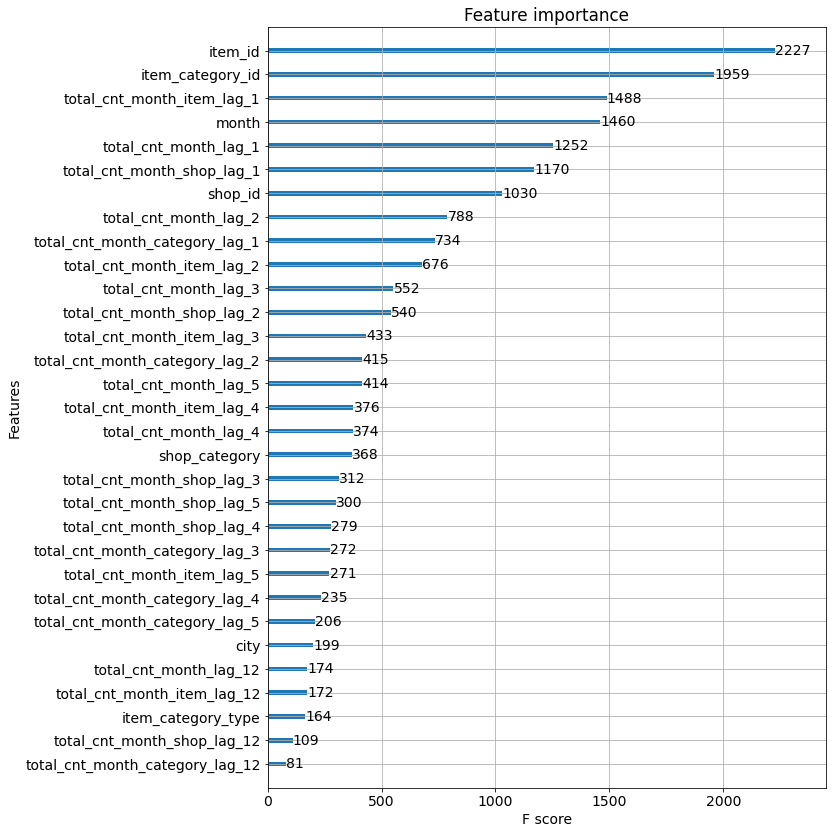

In [209]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(xgb, (10,14))

In [200]:
matrix.dtypes

date_block_num                       int64
shop_id                              int64
item_id                              int64
item_category_id                   float64
total_cnt_month                      int64
index                              float64
city                               float64
city_id                            float64
shop_category                      float64
item_category_type                 float64
month                                int64
total_cnt_month_lag_1              float64
total_cnt_month_lag_2              float64
total_cnt_month_lag_3              float64
total_cnt_month_lag_4              float64
total_cnt_month_lag_5              float64
total_cnt_month_lag_12             float64
total_cnt_month_item_lag_1         float64
total_cnt_month_item_lag_2         float64
total_cnt_month_item_lag_3         float64
total_cnt_month_item_lag_4         float64
total_cnt_month_item_lag_5         float64
total_cnt_month_item_lag_12        float64
total_cnt_m